
# Solution

- Provo a creare nuove colonne aggiuntive

In [339]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [340]:
file_path = './data/rating_stats.csv'
df = pd.read_csv(file_path, delimiter=';')

# Controllo delle prime righe del dataset per visualizzare i dati
df.head()

,id,player_name,player_id,fixture_id,league_round,rating,event_datetime,team_name,position,home_or_away,opponent_team,result,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
0,1,A. Barák,8779,390,1,0.0,17/08/2024 18:30,Fiorentina,Midfielder,away,Parma,1 - 1,D,0,VERO,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,2,A. Barák,8779,392,2,7.3,25/08/2024 18:30,Fiorentina,Midfielder,home,Venezia,0 - 0,D,55,FALSO,0,2,2,0,0,0,0,19,3,17,2,1,0.0,6,2,1,0,2,0,0,0,0,0,0,0,0,0,5.5
2,3,A. Bastoni,8619,384,1,6.9,17/08/2024 18:30,Inter,Defender,away,Genoa,2 - 2,D,90,FALSO,0,0,0,0,0,0,0,72,2,65,2,0,0.0,8,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5
3,4,A. Bastoni,8619,394,2,7.2,24/08/2024 20:45,Inter,Defender,home,Lecce,2 - 0,W,90,FALSO,0,0,0,0,0,0,0,87,0,80,1,0,1.0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,6.5
4,5,A. Bastoni,8619,404,3,7.5,30/08/2024 20:45,Inter,Defender,home,Atalanta,4 - 0,W,61,FALSO,0,0,0,0,0,0,0,47,0,44,2,0,1.0,6,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5


In [341]:
print(df.columns)

Index(['id', 'player_name', 'player_id', 'fixture_id', 'league_round',
       'rating', 'event_datetime', 'team_name', 'position', 'home_or_away',
       'opponent_team', 'result', 'result_status', 'games_minutes',
       'games_substitute', 'offsides', 'shots_total', 'shots_on',
       'goals_total', 'goals_conceded', 'goals_assists', 'goals_saves',
       'passes_total', 'passes_key', 'passes_accuracy', 'tackles_total',
       'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
       'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn',
       'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won',
       'penalty_committed', 'penalty_scored', 'penalty_missed',
       'penalty_saved', 'rating_target'],
      dtype='object')


## Data Preparation

In [342]:
# Filtro colonne
columns_to_keep = [
    'rating', 'position', 'result_status', 'games_minutes',
    'games_substitute', 'offsides', 'shots_total', 'shots_on',
    'goals_total', 'goals_conceded', 'goals_assists', 'goals_saves',
    'passes_total', 'passes_key', 'passes_accuracy', 'tackles_total',
    'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
    'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn',
    'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won',
    'penalty_committed', 'penalty_scored', 'penalty_missed',
    'penalty_saved', 'rating_target'
]

# Filtrare il DataFrame mantenendo solo le colonne specificate
df_filtered = df[columns_to_keep]

df_filtered.head()

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
0,0.0,Midfielder,D,0,VERO,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,7.3,Midfielder,D,55,FALSO,0,2,2,0,0,0,0,19,3,17,2,1,0.0,6,2,1,0,2,0,0,0,0,0,0,0,0,0,5.5
2,6.9,Defender,D,90,FALSO,0,0,0,0,0,0,0,72,2,65,2,0,0.0,8,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5
3,7.2,Defender,W,90,FALSO,0,0,0,0,0,0,0,87,0,80,1,0,1.0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,6.5
4,7.5,Defender,W,61,FALSO,0,0,0,0,0,0,0,47,0,44,2,0,1.0,6,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5


In [343]:
# Filtro righe con games_minutes > 0
# in quanto non rilevanti perché il target sarà 0
# inoltre potrebbe aggiungere rumore al modello

df_filtered = df_filtered[df_filtered['games_minutes'] > 0]
df_filtered

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
1,7.3,Midfielder,D,55,FALSO,0,2,2,0,0,0,0,19,3,17,2,1,0.0,6,2,1,0,2,0,0,0,0,0,0,0,0,0,5.5
2,6.9,Defender,D,90,FALSO,0,0,0,0,0,0,0,72,2,65,2,0,0.0,8,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5
3,7.2,Defender,W,90,FALSO,0,0,0,0,0,0,0,87,0,80,1,0,1.0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,6.5
4,7.5,Defender,W,61,FALSO,0,0,0,0,0,0,0,47,0,44,2,0,1.0,6,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5
6,7.0,Defender,L,82,FALSO,0,0,0,0,0,0,0,60,1,54,1,0,2.0,8,5,0,0,1,2,1,0,0,0,0,0,0,0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,6.6,Attacker,D,71,FALSO,2,1,0,0,0,0,0,7,1,5,0,0,0.0,11,5,1,1,0,3,5,0,0,0,0,0,0,0,6.0
2244,6.9,Attacker,D,67,FALSO,1,1,0,0,0,0,0,6,1,5,0,0,0.0,6,2,2,1,0,1,3,0,0,0,0,0,0,0,6.0
2245,6.6,Attacker,L,90,FALSO,0,2,1,0,0,0,0,24,1,20,0,0,0.0,12,4,8,3,1,0,1,0,0,0,0,0,0,0,5.5
2246,6.9,Attacker,L,90,FALSO,0,1,0,0,0,0,0,13,2,9,0,0,0.0,11,3,2,1,0,2,4,0,0,0,0,0,0,0,5.5


### Feature engeneering

In [344]:
# # colonne positive e negative
positive_cols = ['goals_total', 'goals_assists', 'penalty_scored', 'penalty_saved', 'penalty_won']
negative_cols = ['penalty_missed', 'goals_conceded', 'penalty_committed', 'cards_red', 'cards_yellow']

# # Somma dei valori positivi e negativi
# df_filtered['positive_contributions'] = df_filtered[positive_cols].sum(axis=1)
# df_filtered['negative_contributions'] = df_filtered[negative_cols].sum(axis=1)

# Definisci i pesi per le colonne positive e negative
positive_weights = {
    'goals_total': 3,        # Gol +3
    'goals_assists': 1,      # Assist +1
    'penalty_scored': 3,     # Rigore segnato +3
    'penalty_saved': 3,      # Rigore parato +3
    'penalty_won': 1         # Rigore guadagnato +1
}

negative_weights = {
    'penalty_missed': -3,    # Rigore sbagliato -3
    'goals_conceded': -1,    # Gol subito -1
    'penalty_committed': -1, # Rigore causato -1
    'cards_red': -1,         # Espulsione -1
    'cards_yellow': -0.5     # Ammonizione -0.5
}

# Calcola le contribuzioni positive moltiplicando per i pesi e sommando
df_filtered['positive_contributions'] = sum(df_filtered[col] * positive_weights[col] for col in positive_cols)

# Calcola le contribuzioni negative moltiplicando per i pesi e sommando
df_filtered['negative_contributions'] = sum(df_filtered[col] * negative_weights[col] for col in negative_cols)



df_filtered


,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,positive_contributions,negative_contributions
1,7.3,Midfielder,D,55,FALSO,0,2,2,0,0,0,0,19,3,17,2,1,0.0,6,2,1,0,2,0,0,0,0,0,0,0,0,0,5.5,0,0.0
2,6.9,Defender,D,90,FALSO,0,0,0,0,0,0,0,72,2,65,2,0,0.0,8,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5,0,0.0
3,7.2,Defender,W,90,FALSO,0,0,0,0,0,0,0,87,0,80,1,0,1.0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,6.5,0,0.0
4,7.5,Defender,W,61,FALSO,0,0,0,0,0,0,0,47,0,44,2,0,1.0,6,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5,0,0.0
6,7.0,Defender,L,82,FALSO,0,0,0,0,0,0,0,60,1,54,1,0,2.0,8,5,0,0,1,2,1,0,0,0,0,0,0,0,6.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,6.6,Attacker,D,71,FALSO,2,1,0,0,0,0,0,7,1,5,0,0,0.0,11,5,1,1,0,3,5,0,0,0,0,0,0,0,6.0,0,0.0
2244,6.9,Attacker,D,67,FALSO,1,1,0,0,0,0,0,6,1,5,0,0,0.0,6,2,2,1,0,1,3,0,0,0,0,0,0,0,6.0,0,0.0
2245,6.6,Attacker,L,90,FALSO,0,2,1,0,0,0,0,24,1,20,0,0,0.0,12,4,8,3,1,0,1,0,0,0,0,0,0,0,5.5,0,0.0
2246,6.9,Attacker,L,90,FALSO,0,1,0,0,0,0,0,13,2,9,0,0,0.0,11,3,2,1,0,2,4,0,0,0,0,0,0,0,5.5,0,0.0


In [345]:
# 'games_minutes' step
# Definisci gli intervalli e le etichette
bins = [0, 16, 45, 58, float('inf')]  # Inf significa tutti i minuti superiori a 45
labels = [0, 1, 2, 4]  # Le categorie corrispondenti ai vari step

# Creare la nuova colonna con i livelli
df_filtered['games_minutes_step'] = pd.cut(df_filtered['games_minutes'], bins=bins, labels=labels, right=False)

# Visualizza il risultato
print(df_filtered[['games_minutes', 'games_minutes_step']].head(10))
df_filtered

    games_minutes games_minutes_step
1              55                  2
2              90                  4
3              90                  4
4              61                  4
6              82                  4
7              56                  2
8              58                  2
9              63                  4
10             12                  0
18             18                  1


,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,positive_contributions,negative_contributions,games_minutes_step
1,7.3,Midfielder,D,55,FALSO,0,2,2,0,0,0,0,19,3,17,2,1,0.0,6,2,1,0,2,0,0,0,0,0,0,0,0,0,5.5,0,0.0,2
2,6.9,Defender,D,90,FALSO,0,0,0,0,0,0,0,72,2,65,2,0,0.0,8,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5,0,0.0,4
3,7.2,Defender,W,90,FALSO,0,0,0,0,0,0,0,87,0,80,1,0,1.0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,6.5,0,0.0,4
4,7.5,Defender,W,61,FALSO,0,0,0,0,0,0,0,47,0,44,2,0,1.0,6,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5,0,0.0,4
6,7.0,Defender,L,82,FALSO,0,0,0,0,0,0,0,60,1,54,1,0,2.0,8,5,0,0,1,2,1,0,0,0,0,0,0,0,6.0,0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,6.6,Attacker,D,71,FALSO,2,1,0,0,0,0,0,7,1,5,0,0,0.0,11,5,1,1,0,3,5,0,0,0,0,0,0,0,6.0,0,0.0,4
2244,6.9,Attacker,D,67,FALSO,1,1,0,0,0,0,0,6,1,5,0,0,0.0,6,2,2,1,0,1,3,0,0,0,0,0,0,0,6.0,0,0.0,4
2245,6.6,Attacker,L,90,FALSO,0,2,1,0,0,0,0,24,1,20,0,0,0.0,12,4,8,3,1,0,1,0,0,0,0,0,0,0,5.5,0,0.0,4
2246,6.9,Attacker,L,90,FALSO,0,1,0,0,0,0,0,13,2,9,0,0,0.0,11,3,2,1,0,2,4,0,0,0,0,0,0,0,5.5,0,0.0,4


In [346]:
#df_filtered['passes_accuracy_perc'] = df_filtered['passes_accuracy'] / df_filtered['passes_total']
#df_filtered.head()


### Encoding

In [347]:
# One-Hot Encoding per position
df_encoded = pd.get_dummies(df_filtered, columns=['position'], drop_first=False)
df_encoded

# Ordinal Encoding per result_status
ordinal_encoder = OrdinalEncoder(categories=[['L', 'D', 'W']])
df_encoded['result_status_encoded'] = ordinal_encoder.fit_transform(df_encoded[['result_status']])
df_encoded


# Label Encoding per games_substitute
le = LabelEncoder()
df_encoded['games_substitute_encoded'] = le.fit_transform(df_encoded['games_substitute'].values.ravel())

df_encoded

,rating,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,positive_contributions,negative_contributions,games_minutes_step,position_Attacker,position_Defender,position_Goalkeeper,position_Midfielder,result_status_encoded,games_substitute_encoded
1,7.3,D,55,FALSO,0,2,2,0,0,0,0,19,3,17,2,1,0.0,6,2,1,0,2,0,0,0,0,0,0,0,0,0,5.5,0,0.0,2,False,False,False,True,1.0,0
2,6.9,D,90,FALSO,0,0,0,0,0,0,0,72,2,65,2,0,0.0,8,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5,0,0.0,4,False,True,False,False,1.0,0
3,7.2,W,90,FALSO,0,0,0,0,0,0,0,87,0,80,1,0,1.0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,6.5,0,0.0,4,False,True,False,False,2.0,0
4,7.5,W,61,FALSO,0,0,0,0,0,0,0,47,0,44,2,0,1.0,6,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5,0,0.0,4,False,True,False,False,2.0,0
6,7.0,L,82,FALSO,0,0,0,0,0,0,0,60,1,54,1,0,2.0,8,5,0,0,1,2,1,0,0,0,0,0,0,0,6.0,0,0.0,4,False,True,False,False,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,6.6,D,71,FALSO,2,1,0,0,0,0,0,7,1,5,0,0,0.0,11,5,1,1,0,3,5,0,0,0,0,0,0,0,6.0,0,0.0,4,True,False,False,False,1.0,0
2244,6.9,D,67,FALSO,1,1,0,0,0,0,0,6,1,5,0,0,0.0,6,2,2,1,0,1,3,0,0,0,0,0,0,0,6.0,0,0.0,4,True,False,False,False,1.0,0
2245,6.6,L,90,FALSO,0,2,1,0,0,0,0,24,1,20,0,0,0.0,12,4,8,3,1,0,1,0,0,0,0,0,0,0,5.5,0,0.0,4,True,False,False,False,0.0,0
2246,6.9,L,90,FALSO,0,1,0,0,0,0,0,13,2,9,0,0,0.0,11,3,2,1,0,2,4,0,0,0,0,0,0,0,5.5,0,0.0,4,True,False,False,False,0.0,0


In [348]:
# rimuovo le colonne che non servono più
df = df_encoded.copy()

df['games_substitute'] = df['games_substitute_encoded'].astype(int)
df['result_status'] = df['result_status_encoded'].astype(int)
df['games_minutes'] = df['games_minutes_step'].astype(int)

df = df.drop('games_substitute_encoded', axis=1)
df = df.drop('result_status_encoded', axis=1)
df = df.drop('games_minutes_step', axis=1)

#df = df.drop('passes_accuracy', axis=1)

df.head()

,rating,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,positive_contributions,negative_contributions,position_Attacker,position_Defender,position_Goalkeeper,position_Midfielder
1,7.3,1,2,0,0,2,2,0,0,0,0,19,3,17,2,1,0.0,6,2,1,0,2,0,0,0,0,0,0,0,0,0,5.5,0,0.0,False,False,False,True
2,6.9,1,4,0,0,0,0,0,0,0,0,72,2,65,2,0,0.0,8,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5,0,0.0,False,True,False,False
3,7.2,2,4,0,0,0,0,0,0,0,0,87,0,80,1,0,1.0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,6.5,0,0.0,False,True,False,False
4,7.5,2,4,0,0,0,0,0,0,0,0,47,0,44,2,0,1.0,6,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5,0,0.0,False,True,False,False
6,7.0,0,4,0,0,0,0,0,0,0,0,60,1,54,1,0,2.0,8,5,0,0,1,2,1,0,0,0,0,0,0,0,6.0,0,0.0,False,True,False,False


In [349]:
df.columns

Index(['rating', 'result_status', 'games_minutes', 'games_substitute',
       'offsides', 'shots_total', 'shots_on', 'goals_total', 'goals_conceded',
       'goals_assists', 'goals_saves', 'passes_total', 'passes_key',
       'passes_accuracy', 'tackles_total', 'tackles_blocks',
       'tackles_interceptions', 'duels_total', 'duels_won',
       'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn',
       'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won',
       'penalty_committed', 'penalty_scored', 'penalty_missed',
       'penalty_saved', 'rating_target', 'positive_contributions',
       'negative_contributions', 'position_Attacker', 'position_Defender',
       'position_Goalkeeper', 'position_Midfielder'],
      dtype='object')

### Robust Scaler
Normalizzazione dei dati. Uso Robust Scaler perché meno influenzato dagli outlier, inoltre, mantiene la distribuzione originale dei dati

In [350]:
from sklearn.preprocessing import RobustScaler

numerical_columns = [
    'rating', 'games_minutes', 'offsides', 'shots_total', 'shots_on', 
    'goals_total', 'goals_conceded', 'goals_assists', 'goals_saves', 
    'passes_total', 'passes_key', 'tackles_total', #'passes_accuracy'
    'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
    'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn', 
    'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won', 
    'penalty_committed', 'penalty_scored', 'penalty_missed', 'penalty_saved',
    'games_substitute', 'result_status', 'positive_contributions',
    'negative_contributions', 'position_Attacker', 'position_Defender',
    'position_Goalkeeper', 'position_Midfielder', 'passes_accuracy_perc'
    #'rating_target'
]

data_scaler = RobustScaler()
df_no_target = df.drop(columns=['rating_target'])
df[df_no_target.columns] = data_scaler.fit_transform(df_no_target)


target_scaler = RobustScaler()
df['rating_target'] = target_scaler.fit_transform(df[['rating_target']])


df.head()

,rating,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,positive_contributions,negative_contributions,position_Attacker,position_Defender,position_Goalkeeper,position_Midfielder
1,0.666667,0.0,-0.666667,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,-0.142857,3.0,-0.04,0.5,1.0,0.0,0.000000,-0.25,1.0,0.0,2.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.750000,2.0,1.88,0.5,0.0,0.0,0.333333,0.50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0
3,0.500000,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.285714,0.0,2.48,0.0,0.0,1.0,-0.333333,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0
4,1.000000,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.857143,0.0,1.04,0.5,0.0,1.0,0.000000,0.50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0
6,0.166667,-0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.321429,1.0,1.44,0.0,0.0,2.0,0.333333,0.50,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [351]:
# Salvataggio dello scaler per uso successivo nella fase di post-processing

#caler_filename = './scalers/robust_scaler.pkl'
#import joblib
#joblib.dump(scaler, scaler_filename)

## Suddivisione in train/test e allenamento del modello LightGBM


In [352]:
X = df.drop('rating_target', axis=1)
y = df['rating_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definizione del modello LightGBM con i parametri ottimizzati
lgb_model = lgb.LGBMRegressor(
    learning_rate=0.01,
    max_depth=20,
    n_estimators=500,
    num_leaves=50,
    lambda_l1=0.1,  # ridurre il valore per limitare la regolarizzazione L1
    lambda_l2=0.1   # ridurre il valore per limitare la regolarizzazione L2
)

# Allenamento del modello
lgb_model.fit(X_train, y_train)

# Previsione sui dati di test
y_pred = lgb_model.predict(X_test)

#  performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.4f}, R²: {r2:.4f}')

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 1228, number of used features: 31
[LightGBM] [Info] Start training from score -0.425081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

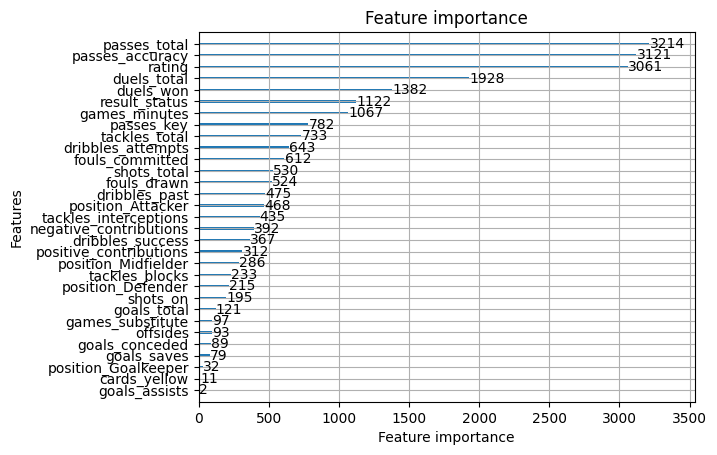

In [353]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_model, max_num_features=50)
plt.show()

In [354]:
# 1. Inverso dello scaling per 'rating_target' su y_test e y_pred
y_test_original = target_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()


y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Valutazione delle performance del modello
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f'RMSE (rating originale): {rmse:.4f}')
print(f'R² (rating originale): {r2:.4f}')

RMSE (rating originale): 1.0913
R² (rating originale): 0.6492


In [355]:
print("y_test_original | y_pred_original")
print("------------------------------")
for y_test, y_pred in zip(y_test_original, y_pred_original):
    print(f"{y_test:<15} | {y_pred:<15}")

y_test_original | y_pred_original
------------------------------
6.5             | 6.053497315873752
6.5             | 6.203010559686149
5.5             | 5.253260293900929
0.0             | 4.474464787514686
6.5             | 6.570808887390569
7.0             | 6.728676495110053
5.0             | 5.499007463806624
6.5             | 5.173757879697134
0.0             | 1.026369837888823
5.5             | 5.4824465537109734
5.5             | 6.154088324612956
5.5             | 5.3965057758020984
7.0             | 6.788976775867757
0.0             | 2.3898008556294075
7.0             | 6.724718565745278
6.0             | 5.45854998753922
5.5             | 5.795270976343014
6.0             | 5.586291562802802
6.0             | 5.85577855253017
5.5             | 5.922992567930319
5.5             | 5.635390205933482
7.5             | 7.029362269506703
0.0             | 1.20988468251851
6.0             | 4.13579065873815
6.0             | 5.945688704863818
0.0             | 5.659635009104134


In [356]:
# Recupera il dataset filtrato basato sugli indici di X_test (il dataset `df_filtered`)
X_test_filtered = df_filtered.loc[X_test.index, :].copy()

# Aggiungi le colonne del 'rating_target' originale e predetto al dataset filtrato
X_test_filtered['rating_target_original'] = y_test_original  # Valori originali del target
X_test_filtered['rating_target_predicted'] = y_pred_original  # Valori predetti (non arrotondati)

significant_columns = ['goals_total', 'goals_assists', 'penalty_scored', 'penalty_saved', 
                       'penalty_missed', 'penalty_committed', 'penalty_won', 'cards_red', 'cards_yellow']

non_significant_columns = [col for col in X_test_filtered.columns if col not in significant_columns + ['position', 'rating', 'result_status', 'games_substitute', 'games_minutes', 'rating_target_original', 'rating_target_predicted']]

# Mappa per sottrarre il valore basato sulla posizione
position_penalties = {
    'Attacker': 1.054198,
    'Defender': 0.825835,
    'Goalkeeper': 0.277365,
    'Midfielder': 0.960583
}

# Logica per gestire gli outliers
X_test_filtered['rating_target_predicted'] = np.where(
    (X_test_filtered['games_minutes'] < 20) & (X_test_filtered['rating_target_predicted'] <= 6),
    # Se games_minutes < 20 e rating_target_predicted < 5
    np.where(
        (X_test_filtered[significant_columns] > 0).any(axis=1) | (X_test_filtered[non_significant_columns].sum(axis=1) >= 22),  
        # Se almeno una colonna significativa è > 0 o la somma delle non significative è >= 20
        X_test_filtered['rating'] - X_test_filtered['position'].map(position_penalties),  # Sottrai il valore in base alla posizione
        0  # Altrimenti assegna 0
    ),
    X_test_filtered['rating_target_predicted']  # Mantieni il valore attuale se la condizione principale non si applica
)

# Arrotondamento al mezzo punto più vicino per i valori predetti
X_test_filtered['rating_target_predicted'] = np.round(X_test_filtered['rating_target_predicted'] * 2) / 2

# salvare il dataset ricostruito su file CSV per ulteriori analisi
X_test_filtered.to_csv('./out/rating_predictions2.csv', index=False)

# Stampa del dataset ricostruito
X_test_filtered.head(20)

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,positive_contributions,negative_contributions,games_minutes_step,rating_target_original,rating_target_predicted
1726,6.9,Defender,W,90,FALSO,0,0,0,0,0,0,0,27,0,22,0,1,0.0,3,1,0,0,0,1,1,0,0,0,0,0,0,0,6.5,0,0.0,4,6.5,6.0
118,7.2,Defender,D,86,FALSO,0,0,0,0,0,0,0,23,2,18,1,1,1.0,4,2,0,0,2,1,0,0,0,0,0,0,0,0,6.5,0,0.0,4,6.5,6.0
494,6.3,Midfielder,L,64,FALSO,0,0,0,0,0,0,0,4,0,2,0,0,0.0,4,2,4,2,0,0,0,0,0,0,0,0,0,0,5.5,0,0.0,4,5.5,5.5
1548,7.0,Attacker,W,11,VERO,0,0,0,0,0,0,0,4,0,4,1,0,0.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0.0
2011,7.0,Defender,W,62,FALSO,0,0,0,0,0,1,0,13,1,8,1,0,0.0,4,2,0,0,1,0,0,0,0,0,0,0,0,0,6.5,1,0.0,4,6.5,6.5
1386,7.3,Defender,W,90,FALSO,0,1,1,1,0,0,0,46,0,39,0,1,2.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,7.0,3,0.0,4,7.0,6.5
1153,6.6,Attacker,D,58,FALSO,0,1,0,0,0,0,0,27,0,21,0,0,0.0,7,4,0,0,0,3,0,0,0,0,0,0,0,0,5.0,0,0.0,2,5.0,5.5
2210,7.2,Defender,L,90,FALSO,0,1,1,0,0,0,0,65,1,57,2,0,1.0,13,9,0,0,0,3,1,0,0,0,0,0,0,0,6.5,0,0.0,4,6.5,5.0
1447,6.6,Attacker,L,9,VERO,0,0,0,0,0,0,0,3,0,2,0,1,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0.0
1777,6.9,Defender,L,90,FALSO,0,0,0,0,0,0,0,49,1,44,1,1,4.0,6,1,0,0,0,0,2,1,0,0,0,0,0,0,5.5,0,-0.5,4,5.5,5.5


In [357]:
df = X_test_filtered.copy()

# differenza tra rating target e rating_target_predicted
df['rating_diff'] = df['rating_target'] - df['rating_target_predicted']

pd.set_option('display.max_columns', None)
df[(abs(df['rating_diff']) > 1)].head(50)

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,positive_contributions,negative_contributions,games_minutes_step,rating_target_original,rating_target_predicted,rating_diff
2210,7.2,Defender,L,90,FALSO,0,1,1,0,0,0,0,65,1,57,2,0,1.0,13,9,0,0,0,3,1,0,0,0,0,0,0,0,6.5,0,0.0,4,6.5,5.0,1.5
470,6.3,Defender,D,12,VERO,0,0,0,0,0,0,0,3,0,1,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0,0.0,0,6.0,0.0,6.0
705,7.3,Midfielder,L,14,VERO,0,0,0,0,0,0,0,5,0,5,0,0,0.0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0.0,1,0.0,0,0.0,6.5,-6.5
1648,6.3,Attacker,W,12,VERO,0,2,1,0,0,0,0,4,0,2,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,5.5,0,0.0,0,5.5,0.0,5.5
533,7.2,Goalkeeper,D,90,FALSO,0,0,0,0,0,0,3,27,0,13,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.5,0,0.0,4,7.5,6.0,1.5
1232,6.7,Midfielder,L,63,FALSO,0,1,0,0,0,0,0,42,1,40,0,1,1.0,3,1,0,0,1,0,1,0,0,0,1,0,0,0,4.0,0,-1.0,4,4.0,5.5,-1.5
1551,6.9,Defender,D,90,FALSO,0,1,1,0,0,0,0,58,0,52,1,0,1.0,10,8,0,0,0,0,1,0,0,0,0,0,0,0,4.5,0,0.0,4,4.5,6.0,-1.5
1423,6.7,Midfielder,W,11,VERO,0,0,0,0,0,0,0,11,1,11,0,0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,5.5,-5.5


In [358]:
df[(abs(df['rating_diff']) >= 1) & (df['games_minutes'] < 20)].head(50)
#df[(abs(df['rating_diff']) >= 1) & (df['games_minutes'] < 20)][non_significant_columns].sum(axis=1) #.head(50)


,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,positive_contributions,negative_contributions,games_minutes_step,rating_target_original,rating_target_predicted,rating_diff
470,6.3,Defender,D,12,VERO,0,0,0,0,0,0,0,3,0,1,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0,0.0,0,6.0,0.0,6.0
705,7.3,Midfielder,L,14,VERO,0,0,0,0,0,0,0,5,0,5,0,0,0.0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0.0,1,0.0,0,0.0,6.5,-6.5
1648,6.3,Attacker,W,12,VERO,0,2,1,0,0,0,0,4,0,2,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,5.5,0,0.0,0,5.5,0.0,5.5
1554,6.2,Midfielder,D,19,VERO,0,1,0,0,0,0,0,4,0,2,0,0,0.0,5,0,0,0,1,0,2,0,0,0,0,0,0,0,6.0,0,0.0,1,6.0,5.0,1.0
1423,6.7,Midfielder,W,11,VERO,0,0,0,0,0,0,0,11,1,11,0,0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,5.5,-5.5


In [359]:
# Perc di record con rating_diff > 1
print("% rec con rating_diff > 1: ", len(df[(abs(df['rating_diff']) > 1)]) / len(df) * 100)

# Perc di record con rating_diff >= 1
print("% rec con rating_diff >= 1: ", len(df[(abs(df['rating_diff']) >= 1)]) / len(df) * 100)


% rec con rating_diff > 1:  2.5974025974025974
% rec con rating_diff >= 1:  11.363636363636363


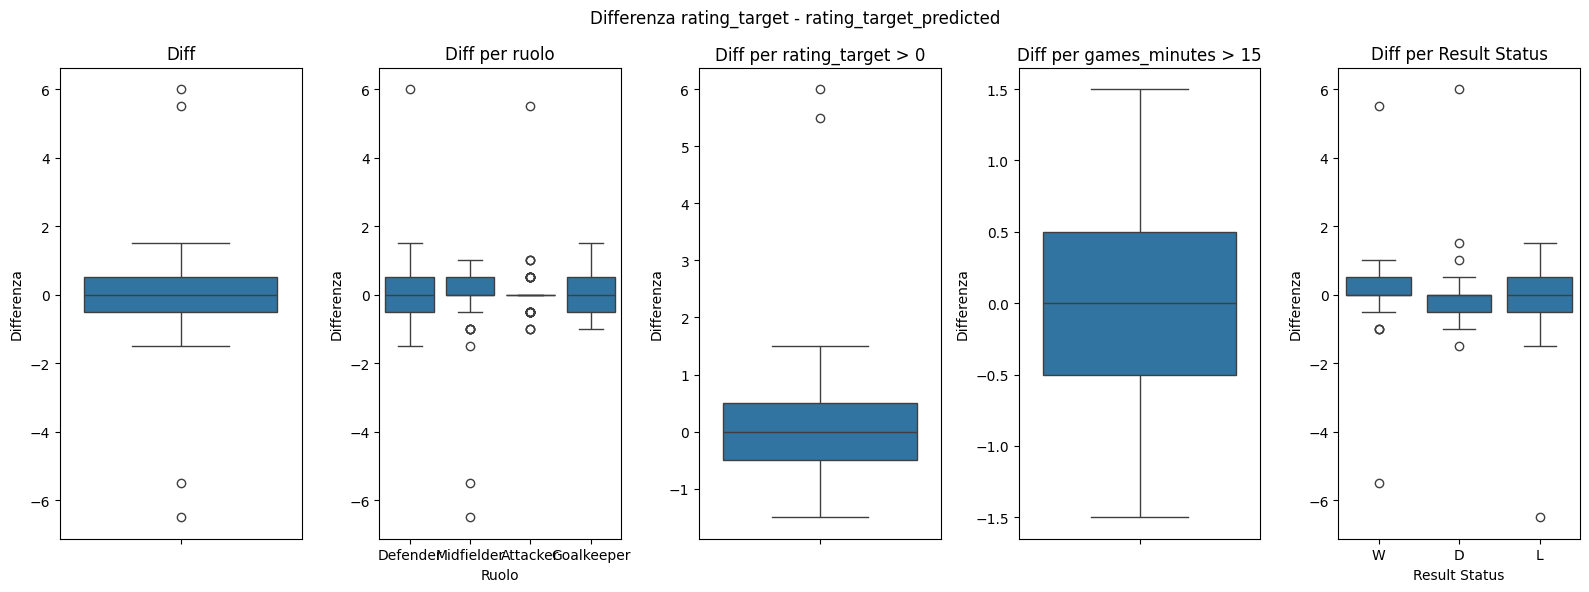

In [360]:
# Stats di base sulla differenza tra rating e rating target
diff_overall = df['rating_diff'].describe()

# Statistiche di base sulla differenza, raggruppata per ruolo (position)
diff_by_position = df.groupby('position')['rating_diff'].describe()

# Filtrare righe con rating_target > 0
filtered_df = df[(df['rating_target'] > 0)]
diff_filtered = filtered_df['rating_diff'].describe()

# Impostazioni per i grafici
plt.figure(figsize=(16, 6))
plt.suptitle("Differenza rating_target - rating_target_predicted")

# Boxplot della differenza complessiva tra rating_target e rating
plt.subplot(1, 5, 1)
sns.boxplot(y=df['rating_diff'])
plt.title('Diff')
plt.ylabel('Differenza')

# Boxplot della differenza per ruolo (position)
plt.subplot(1, 5, 2)
sns.boxplot(x=df['position'], y=df['rating_diff'])
plt.title('Diff per ruolo')
plt.xlabel('Ruolo')
plt.ylabel('Differenza')

# Boxplot delle righe filtrate con rating_target > 0
filtered_df = df[df['rating_target'] > 0]
plt.subplot(1, 5, 3)
sns.boxplot(y=filtered_df['rating_diff'])
plt.title('Diff per rating_target > 0')
plt.ylabel('Differenza')

# 3. Boxplot delle righe filtrate con games_minutes > 15
filtered_df = df[df['games_minutes'] > 15]
plt.subplot(1, 5, 4)
sns.boxplot(y=filtered_df['rating_diff'])
plt.title('Diff per games_minutes > 15')
plt.ylabel('Differenza')

# 4. Boxplot della differenza rispetto a result_status
plt.subplot(1, 5, 5)
sns.boxplot(x=df['result_status'], y=df['rating_diff'])
plt.title('Diff per Result Status')
plt.xlabel('Result Status')
plt.ylabel('Differenza')

plt.tight_layout()
plt.show()

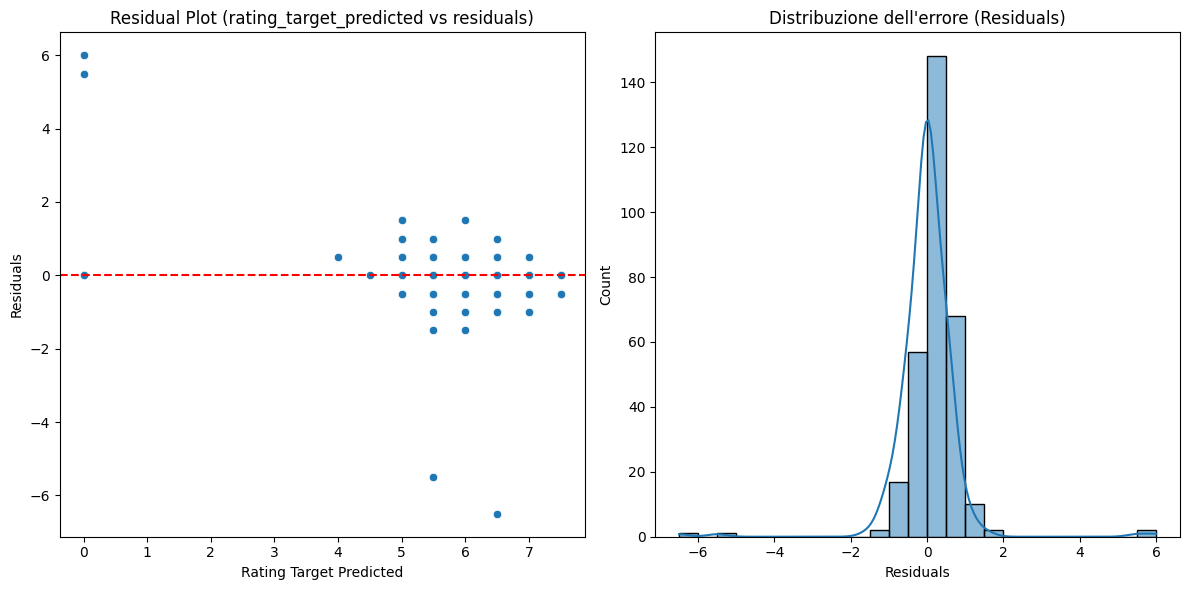

In [361]:
# 1. Residual Plot (Grafico dei residui)
plt.figure(figsize=(12, 6))

# Calcolare i residui (errore)
df['residuals'] = df['rating_target'] - df['rating_target_predicted']

# Residual plot: rating_target vs residui
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['rating_target_predicted'], y=df['residuals'])
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (rating_target_predicted vs residuals)')
plt.xlabel('Rating Target Predicted')
plt.ylabel('Residuals')

# Distribuzione dell'errore
plt.subplot(1, 2, 2)
sns.histplot(df['residuals'], kde=True, bins=25)
plt.title('Distribuzione dell\'errore (Residuals)')
plt.xlabel('Residuals')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [362]:
# Errore medio assoluto (MAE)
mae = np.mean(np.abs(df['residuals']))
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calcola l'RMSE
rmse = root_mean_squared_error(df['rating_target'], df['rating_target_predicted'])

print("RMSE:", rmse)

Mean Absolute Error (MAE): 0.39
RMSE: 0.8178209882554793
